In [1]:
import numpy as np
import torch

In [2]:
!ls

1.ipynb				 ngrams
adafactor.py			 non_iid_dataloader.py
attn.npy			 plain_text
attns				 __pycache__
checkpoints			 rubbish_bin
conv.flac			 scripts
create_tokenizer		 testd.wav
cross_attn_exam.ipynb		 test.wav
eval_1000_ctc.sh		 tokenizer_spe_bpe_v1000
eval_char_ctc.sh		 tokenizer_spe_bpe_v128
eval_ctc_h_init.py		 tokenizer_spe_char
eval_ctc.py			 tools.py
eval_ctc_reuse.py		 train_H.py
eval_logits			 train_long_context.sh
eval.py				 train.py
eval_script_shuffle_test.sh	 train_rand.py
eval_sc_small_ctc_cfg.sh	 train_sc_ctc.py
eval_small_transducer.sh	 train.sh
Hconf_sched_sccrosscontext.json  train_small_ctc_grouped.sh
hyps.json			 train_small_ctc.sh
hypst.json			 train_small_H_ctc.sh
log.txt				 train_small_H_ctc_test.sh
longcontext.json		 train_transducer.py
model_utils.py			 wandb


In [3]:
import non_iid_dataloader as niiddl
import tools

[NeMo W 2022-09-29 14:02:02 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.
[NeMo W 2022-09-29 14:02:03 experimental:27] Module <class 'nemo.collections.nlp.data.language_modeling.megatron.megatron_batch_samplers.MegatronPretrainingRandomBatchSampler'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-09-29 14:02:04 experimental:27] Module <class 'nemo.collections.nlp.models.text_normalization_as_tagging.thutmose_tagger.ThutmoseTaggerModel'> is experimental, not ready for production and is not fully supported. Use at your own risk.


In [4]:
from einops import rearrange, repeat, reduce
from tqdm import tqdm
from lhotse import CutSet
from lhotse.cut import Cut
from lhotse.utils import Seconds
from typing import Optional, Sequence
from tools import isfalse, istrue
import lhotse

In [5]:
corpus = tools.load_corpus()

In [6]:
def plain_concat(cuts: Sequence[Cut], gap: Seconds = 0.5, max_duration=None, seperate_speakers=False, concat_cuts=True) -> CutSet:
    """
    A simple concatenation of cuts, maintaining original order.
    cuts: a lhotse sequence of cuts
    gap: the duration of silence inserted between concatenated cuts.
    max_duration: the maximum duration of the concatenated cut (seconds). If None, no limit is applied.
    seperate_speakers: whether to include seperate speakers in the same utterance, pass list of speakers to seperate
    concat_cuts: whether to concatenate cuts or just join into individual cutsets and return a list of cutsets
    """
    if len(cuts) <= 1:
        # Nothing to do.
        return CutSet.from_cuts(cuts)
    assert isfalse(seperate_speakers) or seperate_speakers.__class__.__name__ == 'list', "seperate_speakers must be a list of speakers to seperate" 
 
    max_duration = max_duration if max_duration is not None else float('inf')

    cutlist = [cuts[0]] if concat_cuts else [[cuts[0]]]
    prev_speaker = None if isfalse(seperate_speakers) else seperate_speakers[0]
    cur_duration = cuts[0].duration 

    for i in range(1, len(cuts)):
        cut = cuts[i]
        cur_speaker = None if isfalse(seperate_speakers) else seperate_speakers[i]

        if cur_speaker == prev_speaker and (cur_duration + gap + cut.duration) <= max_duration:
            cutlist[-1] = cutlist[-1].pad(cutlist[-1].duration + gap).append(cut) if concat_cuts else cutlist[-1] + [cut]
            cur_duration += gap + cut.duration
        else:
            cutlist.append(cut if concat_cuts else [cut])
            cur_duration = cut.duration

        prev_speaker = cur_speaker

    return [CutSet.from_cuts([cut] if concat_cuts else cut) for cut in cutlist]


In [7]:
def get_speakers(cut):
    return [el.supervisions[0].speaker for el in cut] 

In [8]:
get_speakers(meetings[(list(meetings.keys())[0])])

NameError: name 'meetings' is not defined

In [13]:
meetings = niiddl.prepare_partition(corpus['test'])

In [ ]:
sep_speaks = [el.supervisions[0].speaker for el in meetings[(list(meetings.keys())[0])]]

In [ ]:
a = plain_concat(meetings[(list(meetings.keys())[0])], max_duration=25, seperate_speakers=sep_speaks, concat_cuts=False)

In [ ]:
a

[CutSet(len=1) [underlying data type: <class 'dict'>],
 CutSet(len=2) [underlying data type: <class 'dict'>],
 CutSet(len=4) [underlying data type: <class 'dict'>],
 CutSet(len=3) [underlying data type: <class 'dict'>],
 CutSet(len=1) [underlying data type: <class 'dict'>],
 CutSet(len=1) [underlying data type: <class 'dict'>],
 CutSet(len=1) [underlying data type: <class 'dict'>],
 CutSet(len=1) [underlying data type: <class 'dict'>],
 CutSet(len=2) [underlying data type: <class 'dict'>],
 CutSet(len=1) [underlying data type: <class 'dict'>],
 CutSet(len=1) [underlying data type: <class 'dict'>],
 CutSet(len=3) [underlying data type: <class 'dict'>],
 CutSet(len=4) [underlying data type: <class 'dict'>],
 CutSet(len=1) [underlying data type: <class 'dict'>],
 CutSet(len=2) [underlying data type: <class 'dict'>],
 CutSet(len=1) [underlying data type: <class 'dict'>],
 CutSet(len=1) [underlying data type: <class 'dict'>],
 CutSet(len=2) [underlying data type: <class 'dict'>],
 CutSet(le

In [ ]:
lhotse.CutSet.from_cuts(meetings[(list(meetings.keys())[0])][0:2])

CutSet(len=2) [underlying data type: <class 'dict'>]

In [9]:
lhotse.CutSet.from_cuts([a[0], a[1]])

NameError: name 'a' is not defined

In [10]:
utts

NameError: name 'utts' is not defined

In [11]:
np.array([el.duration for el in utts]).mean()

NameError: name 'utts' is not defined

In [71]:
samples = niiddl.prepare_samples(meetings, max_duration=60, concat_samples=True, split_speakers=True)

In [108]:
samples[15][0].load_audio().squeeze().shape[0] /16000

52.881

In [107]:
[el.text for el in samples[15][0].supervisions]

["'kay my name is freek van ponnen i'm the market expert but you already knew that",
 "um i've done some research we have we uh have been doing research in a usability lab where we observed",
 'um users operating remote controls uh we let them fill out a questionnaire',
 'we had one hundred of these uh test subjects',
 'uh in addition we did some market research uh see what the market consists of what ages are involved',
 'well these are three quite astonishing results i thought um remotes are being considered ugly f uh seventy five percent of the um',
 'people questioned uh indicated that they thought their remote were was ugly um and an additional eighty percent indicated that they would spend more money on a fancy looking remote control so']

In [109]:
import soundfile as sf
sf.write('test.wav', samples[15][0].load_audio().squeeze()*10, 16000)

In [99]:
np.array([el[10].duration for el in samples]).max()

StopIteration: 

In [410]:
meetings[(list(meetings.keys())[0])][5].duration

6.54

In [8]:
samples[0][1].supervisions[0].speaker

'MTD012ME'

In [23]:
CutSet.from_cuts([samples[0][0], samples[0][1], samples[0][2]])

CutSet(len=3) [underlying data type: <class 'dict'>]

In [15]:
samples[0][0]

MonoCut(id='25d0ad5d-b5fa-4ee4-9e3d-a1130bc7e5b1', start=0, duration=14.477, channel=0, supervisions=[SupervisionSegment(id='TS3003b-0-0', recording_id='TS3003b', start=0.05, duration=14.376999999999995, channel=0, text="okay everybody found his place again yeah that's nice okay so this is our second meeting and uh still failing", language='English', speaker='MTD009PM', gender='M', custom={'segment_start': 56.762, 'segment_end': 71.139}, alignment={'word': [AlignmentItem(symbol='okay', start=0.398, duration=0.3999999999999986), AlignmentItem(symbol='everybody', start=0.798, duration=0.6600000000000037), AlignmentItem(symbol='found', start=1.458, duration=0.22999999999999687), AlignmentItem(symbol='his', start=1.688, duration=0.14999999999999858), AlignmentItem(symbol='place', start=1.838, duration=0.7000000000000028), AlignmentItem(symbol='again', start=2.538, duration=0.7700000000000031), AlignmentItem(symbol='yeah', start=3.308, duration=1.2199999999999989), AlignmentItem(symbol="tha

In [7]:
samples[0][3].append(samples[0][4])

MixedCut(id='362e5df1-2b27-4aa1-975d-ebe42f40309d', tracks=[MixTrack(cut=MonoCut(id='45a59f94-f2d6-4518-a96e-2dda7fd452d6', start=0, duration=6.23, channel=0, supervisions=[SupervisionSegment(id='TS3003b-0-1_0', recording_id='TS3003b', start=0.05, duration=6.1299999999999955, channel=0, text="uh now we're going um into the functional design um", language='English', speaker='MTD009PM', gender='M', custom={'segment_start': 72.76, 'segment_end': 78.89}, alignment={'word': [AlignmentItem(symbol='uh', start=0.05, duration=0.28999999999999204), AlignmentItem(symbol='now', start=0.34, duration=0.21000000000000796), AlignmentItem(symbol="we're", start=0.55, duration=0.1599999999999966), AlignmentItem(symbol='going', start=0.71, duration=0.46999999999999886), AlignmentItem(symbol='um', start=1.18, duration=1.0400000000000063), AlignmentItem(symbol='into', start=2.22, duration=0.29999999999999716), AlignmentItem(symbol='the', start=2.52, duration=0.0899999999999892), AlignmentItem(symbol='functi

In [8]:
samples[0]

CutSet(len=21) [underlying data type: <class 'dict'>]

In [32]:
import lhotse
from lhotse.dataset.cut_transforms import concatenate

In [10]:
from importlib import reload as rl

In [33]:
rl(concatenate)

<module 'lhotse.dataset.cut_transforms.concatenate' from '/exp/exp1/acp21rjf/lhotse/lhotse/dataset/cut_transforms/concatenate.py'>

In [21]:
lhotse.dataset.cut_transforms.plain_concat

<function lhotse.dataset.cut_transforms.concatenate.plain_concat(cuts: Sequence[lhotse.cut.Cut], gap: float = 1.0) -> lhotse.cut.CutSet>

In [52]:
" -- ".join([el.supervisions[0].text for el in samples[0]])

"okay everybody found his place again yeah that's nice okay so this is our second meeting and uh still failing -- yes -- yeah -- uh now we're going um into the functional design um -- important thing of this phase is that we're going to uh try to -- get an agreement about the user requirements technical function design and -- the working design -- so that we can move onto the second uh phase but first this phase -- um first an announcement there's a little adaptation in the air conditioning -- system so --  -- there's our ghost mouse again that that means that you can have a little trouble with little trouble with the air conditioning that's because of this uh -- okay -- okay -- it's in wing c and e so it should be over in a in a while couple of days -- but it's going to be cold anyway so i don't think you're gonna need it then --  -- no -- our agenda now first the opening uh this time i will take the minutes -- uh you're going to have a presentation all of you um -- and we've got fort

In [57]:
" ".join([el.text for el in concatenate.plain_concat(samples[0], gap=0.2)[0].supervisions])

"okay everybody found his place again yeah that's nice okay so this is our second meeting and uh still failing yes yeah uh now we're going um into the functional design um important thing of this phase is that we're going to uh try to get an agreement about the user requirements technical function design and the working design so that we can move onto the second uh phase but first this phase um first an announcement there's a little adaptation in the air conditioning system so  there's our ghost mouse again that that means that you can have a little trouble with little trouble with the air conditioning that's because of this uh okay okay it's in wing c and e so it should be over in a in a while couple of days but it's going to be cold anyway so i don't think you're gonna need it then  no our agenda now first the opening uh this time i will take the minutes uh you're going to have a presentation all of you um and we've got forty minutes for the whole uh prese for the whole uh presentati

In [19]:
dl = niiddl.get_eval_dataloader(corpus['test'], max_sample_size=3, allowed_range=1, batch_size=15, concat_samples=True)

In [20]:
utt_lens = []
for i in tqdm(dl):
    sample = i
    utt_lens += (sample['audio_lens'] / (16000)).tolist()
utt_lens = np.array(utt_lens)
print('average length (seconds)', utt_lens.mean())

100%|██████████| 276/276 [00:12<00:00, 21.60it/s]

average length (seconds) 8.653121896608853


In [21]:
8.653121896608853/3.5078556697642465

2.466783901970062

In [49]:
utt_lens.shape[0]//2

590

In [64]:
sorted(utt_lens)[int(utt_lens.shape[0]*0.05)    ]

15.715999603271484

In [10]:
dl = niiddl.get_eval_dataloader(corpus['test'], max_sample_size=60, allowed_range=1, batch_size=30)

In [12]:
for i in dl:
    sample = i
    break

In [15]:
class padding_manager():
    def __init__(self, sub_batch_sizes):
        self.sb_indices = None
        self.sb_masks = None
        self.revert_indices = None
        self.sub_batch_sizes = sub_batch_sizes

        self.ds_lengths = None
        self.ds_total_sb_lengths = None
        self.max_ds_total_sb_lengths = None
      
    def convert_to_subbatches(self, ds, ds_lengths):
        self.ds_lengths = ds_lengths
        b, t, d, sub_batch_sizes = *ds.shape, self.sub_batch_sizes
        flat_sequences = rearrange(ds, 'b t d -> (b t) d')
        padding_index = torch.zeros(1, d).to(ds.device)
        flat_sequence_with_padding_index = torch.cat([flat_sequences, padding_index], dim=0)

        if self.sb_indices != None: # if cached then don't recompute
            return flat_sequence_with_padding_index[self.sb_indices], self.sb_masks

        #ds_sb_lengths = torch.split(ds_lengths, sub_batch_sizes.tolist()) # list of utterance lengths within each sub-batch
        max_ds_lengths = torch.full((b,), ds_lengths.max(), dtype=torch.long, device=ds.device) # max length of utterance in each sub-batch i.e with the padding
        culm_max_ds_lengths = torch.cumsum(max_ds_lengths, dim=0) # culmulative sum of max lengths of utterances in each sub-batch
        culm_max_ds_lengths_start = culm_max_ds_lengths - ds_lengths.max() # start of each utterance in the flat sequence
        # split these into sub-batches
        culm_max_ds_lengths_start_sb = torch.split(culm_max_ds_lengths_start, sub_batch_sizes.tolist()) # list of start indices of each utterance in each sub-batch within the flat sequence
        culm_ds_lengths_end_sb = torch.split(culm_max_ds_lengths_start + ds_lengths, sub_batch_sizes.tolist()) # list of end indices of each utterance in each sub-batch within the flat sequence
        ds_total_sb_lengths = [el.sum().item() for el in torch.split(ds_lengths, sub_batch_sizes.tolist())] # list of total lengths of each sub-batch
        self.ds_total_sb_lengths = ds_total_sb_lengths
        max_ds_total_sb_lengths = max(ds_total_sb_lengths) # max total length of all sub-batches
        self.max_ds_total_sb_lengths = max_ds_total_sb_lengths
        # now get the indices
        all_sb_indices = []
        all_sb_pad_masks = []
        for culm_max_ds_length_start_sb, culm_ds_length_end_sb in zip(culm_max_ds_lengths_start_sb, culm_ds_lengths_end_sb):
            sb_indices = []
            for start, end in zip(culm_max_ds_length_start_sb, culm_ds_length_end_sb):
                sb_indices.append(torch.arange(start, end))
            sb_indices = torch.cat(sb_indices)
            diff_from_max_length = max_ds_total_sb_lengths - sb_indices.shape[0]
            # pad with -1 which will be used to grab the padding from the flat sequence
            sb_indices = torch.cat([sb_indices, torch.full((diff_from_max_length,), -1, dtype=torch.long)])
            cur_pad_mask = torch.zeros(sb_indices.shape[0], dtype=torch.bool) # create a mask for the padding
            cur_pad_mask[sb_indices == -1] = True # set the padding mask to True where the padding is ;)
            all_sb_pad_masks.append(cur_pad_mask)
            all_sb_indices.append(sb_indices)
        all_sb_pad_masks = torch.stack(all_sb_pad_masks)
        all_sb_indices = torch.stack(all_sb_indices)
        # okay now we have the indices, we can grab the flat sequences
        all_sb_pad_masks = all_sb_pad_masks.to(ds.device)
        self.sb_indices = all_sb_indices
        self.sb_masks = all_sb_pad_masks
        
        return flat_sequence_with_padding_index[all_sb_indices], all_sb_pad_masks


    def revert_from_subbatches(self, ds_sb_sequences):
        assert self.sb_indices != None, "You need to call convert_to_subbatches first"
        b, t, d, sub_batch_sizes, ds_lengths, max_ds_total_sb_lengths, ds_total_sb_lengths = *ds_sb_sequences.shape, self.sub_batch_sizes, self.ds_lengths, self.max_ds_total_sb_lengths, self.ds_total_sb_lengths
        reflat_sequences = rearrange(ds_sb_sequences, 'b t d -> (b t) d')
        padding_index = torch.zeros(1, d).to(ds_sb_sequences.device)
        reflat_sequence_with_padding_index = torch.cat([reflat_sequences, padding_index], dim=0)
        
        if self.revert_indices != None: # if cached then don't recompute
            return reflat_sequence_with_padding_index[self.revert_indices]

        ds_sb_lengths = torch.split(ds_lengths, sub_batch_sizes.tolist())
        all_revert_indices = []
        pos = 0

        for ds_sb_length, ds_total_sb_length in zip(ds_sb_lengths, ds_total_sb_lengths):
            cur_revert_indices = []
            for utt_length in ds_sb_length:
                cur_indices = torch.arange(pos, pos+utt_length)
                diff_from_max_length = ds_lengths.max() - cur_indices.shape[0]
                cur_indices = torch.cat([cur_indices, torch.full((diff_from_max_length,), -1, dtype=torch.long)])
                cur_revert_indices.append(cur_indices)
                pos += utt_length
            pos += max_ds_total_sb_lengths - ds_total_sb_length
            all_revert_indices.append(torch.stack(cur_revert_indices))
        all_revert_indices = torch.cat(all_revert_indices)

        self.revert_indices = all_revert_indices
        return reflat_sequence_with_padding_index[all_revert_indices]

In [28]:
def printstuff(*args):
    for i, arg in enumerate(args):
        print(f'{i}\n{arg}')

In [33]:
printstuff(sample['audio'].shape, sample['audio_lens'], sample['segment_lens'], sample['segment_lens'].sum())

0
torch.Size([1929, 241328])
1
tensor([231632,  15072,  11296,  ...,  29920, 102240,  99680],
       dtype=torch.int32)
2
tensor([68, 67, 67, 67, 67, 67, 67, 67, 64, 63, 63, 63, 63, 63, 64, 63, 63, 63,
        63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 65, 65])
3
1929


In [30]:
padman = padding_manager(sample['segment_lens'])

In [32]:
sample['audio'].shape

torch.Size([1929, 241328])

In [34]:
data = sample['audio'].unsqueeze(-1)

In [35]:
data.shape

torch.Size([1929, 241328, 1])

In [49]:
sbs, sbmasks = padman.convert_to_subbatches(data, sample['audio_lens'])
sbs = sbs.squeeze()

In [52]:
import soundfile as sf

In [77]:
def save_tensor_as_wav(tensor, path, multiplier=20):
    tensor = tensor.cpu().squeeze().numpy() * multiplier
    sf.write(path, tensor, 16000)

In [86]:
num = -2
save_tensor_as_wav(sbs[num][:sbmasks[num][sbmasks[num] == False].shape[0]], 'testd.wav')

In [85]:
sbmasks[-2][sbmasks[-2] == False].shape[0]

4537808

In [79]:
sample['segment_lens']

tensor([68, 67, 67, 67, 67, 67, 67, 67, 64, 63, 63, 63, 63, 63, 64, 63, 63, 63,
        63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 65, 65])

In [76]:
" ".join([el[0] + "  --  " for el in sample['text'][-65*2:-65]])

"help  --   it's up there that screen's black  --     --     --   alright okay okay that's fine  --   oh god  --   are we done  --   right okay um this is our second meeting and i might be a bit all over the place um right our agenda for today do you want us to give you a second  --     --   uh no that's okay sorry  --   okay um  --   i'll go over what we decided last meeting  --   mm hmm  --   um  --   we decided upon a universal control one handset for all t v video  --   sorry  --   equipment um that it was important that the product was accessible to a wide range  --   of consumers wide age range not limiting anyone we decided it was important  --   to reflect the company's image in our product we put fashion in electronics you know that kind of  --   s thing um our budget would have to affect um  --   try not to reflect our budget um that we might  --   have a bit of oh oh you can see it okay um dissonance between what our budget was and what we want it to look like um  --     -- 

In [257]:
from tools import load_json
from nemo.collections.asr.metrics.wer import word_error_rate

In [258]:
!ls *.json

Hconf_sched_sccrosscontext.json  hyps.json  longcontext.json


In [354]:
outs = load_json('hypst.json')

In [355]:
max_len

2233

In [365]:
interval = 20
max_len = max([len(el) for el in outs['refs']])
len_bins_start = [i for i in range(0, max_len, interval)]
len_bins_end = [i for i in range(interval, max_len+interval, interval)]
len_bins = list(zip(len_bins_start, len_bins_end))

def get_bin_index(length):
    for i, (start, end) in enumerate(len_bins):
        if start <= length < end:
            return i
    return -1

bin_dict = {i: {'refs': [], 'hyps': []} for i in range(len(len_bins))}

for i in range(len(outs['hyps'])):
    length = len(outs['refs'][i])
    bin_index = get_bin_index(length)
    bin_dict[bin_index]['refs'].append(outs['refs'][i])
    bin_dict[bin_index]['hyps'].append(outs['hyps'][i])
    
for k in bin_dict.keys():
    wer = word_error_rate(hypotheses=bin_dict[k]['hyps'], references=bin_dict[k]['refs'], use_cer=False)
    cer = word_error_rate(hypotheses=bin_dict[k]['hyps'], references=bin_dict[k]['refs'], use_cer=True)
    bin_dict[k]['wer'] = wer * 100
    bin_dict[k]['cer'] = cer * 100

In [366]:
[bin_dict[i]['wer'] for i in range(len(len_bins))]

[59.6126594237128,
 40.46830130329136,
 35.6120826709062,
 30.441454202077434,
 29.35304990757856,
 26.891813431391526,
 28.395681646999748,
 27.788546255506606,
 28.856328856328854,
 26.163328197226505,
 26.2433267771846,
 24.80974124809741,
 28.129531174480427,
 27.289719626168225,
 28.97125567322239,
 28.992628992628994,
 25.238095238095237,
 24.210526315789473,
 26.055312954876275,
 19.854721549636803,
 26.34228187919463,
 26.77165354330709,
 18.849449204406366,
 24.735729386892178,
 23.809523809523807,
 26.879699248120303,
 19.565217391304348,
 25.423728813559322,
 19.91701244813278,
 inf,
 3.418803418803419,
 24.576271186440678,
 24.166666666666668,
 inf,
 18.4,
 24.0,
 inf,
 30.87248322147651,
 16.587677725118482,
 inf,
 13.88888888888889,
 inf,
 18.06853582554517,
 inf,
 20.588235294117645,
 inf,
 15.341959334565619,
 inf,
 inf,
 22.432432432432435,
 22.22222222222222,
 inf,
 24.056603773584907,
 19.19191919191919,
 inf,
 inf,
 13.24200913242009,
 inf,
 inf,
 inf,
 inf,
 inf,
 

In [367]:
bin_sizes = [len(bin_dict[i]['refs']) for i in range(len(len_bins))]
bin_sizes

[2744,
 733,
 607,
 585,
 592,
 467,
 304,
 187,
 144,
 83,
 84,
 56,
 41,
 20,
 23,
 13,
 19,
 7,
 9,
 5,
 7,
 3,
 9,
 5,
 5,
 5,
 3,
 1,
 2,
 0,
 1,
 2,
 1,
 0,
 1,
 1,
 0,
 1,
 3,
 0,
 1,
 0,
 2,
 0,
 1,
 0,
 3,
 0,
 0,
 2,
 2,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1]

In [359]:
from matplotlib import pyplot as plt

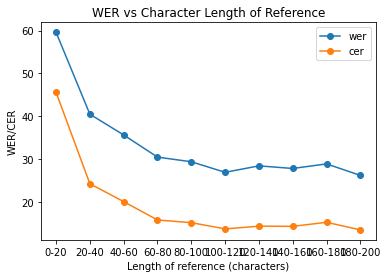

In [368]:
data_wer = [bin_dict[i]['wer'] for i in range(len(len_bins))][:10]
data_cer = [bin_dict[i]['cer'] for i in range(len(len_bins))][:10]
keys = [f'{start}-{end}' for start, end in len_bins][:10]
# rotation=90
plt.plot(keys, data_wer, 'o-', label='wer')
plt.plot(keys, data_cer, 'o-', label='cer')
plt.xlabel('Length of reference (characters)')
plt.ylabel('WER/CER')
plt.title('WER vs Character Length of Reference')
plt.legend()
plt.show()

In [372]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [374]:
outs['encoded_lens'] = flatten(outs['encoded_lens'])

In [377]:
interval = 20
max_len = max([el for el in outs['encoded_lens']])
len_bins_start = [i for i in range(0, max_len, interval)]
len_bins_end = [i for i in range(interval, max_len+interval, interval)]
len_bins = list(zip(len_bins_start, len_bins_end))

def get_bin_index(length):
    for i, (start, end) in enumerate(len_bins):
        if start <= length < end:
            return i
    return -1

bin_dict = {i: {'refs': [], 'hyps': []} for i in range(len(len_bins))}

for i in range(len(outs['hyps'])):
    length = outs['encoded_lens'][i]
    bin_index = get_bin_index(length)
    bin_dict[bin_index]['refs'].append(outs['refs'][i])
    bin_dict[bin_index]['hyps'].append(outs['hyps'][i])
    
for k in bin_dict.keys():
    wer = word_error_rate(hypotheses=bin_dict[k]['hyps'], references=bin_dict[k]['refs'], use_cer=False)
    cer = word_error_rate(hypotheses=bin_dict[k]['hyps'], references=bin_dict[k]['refs'], use_cer=True)
    bin_dict[k]['wer'] = wer *100
    bin_dict[k]['cer'] = cer *100

In [380]:
bin_sizes = [len(bin_dict[i]['refs']) for i in range(len(len_bins))]
print(bin_sizes)
print(bin_sizes[0:20])

[972, 1133, 645, 455, 365, 268, 263, 659, 436, 344, 186, 156, 118, 89, 92, 78, 83, 79, 92, 38, 30, 19, 12, 16, 11, 16, 9, 12, 13, 3, 4, 1, 10, 7, 2, 3, 3, 3, 1, 3, 0, 5, 4, 1, 3, 2, 1, 4, 2, 2, 1, 0, 1, 0, 1, 0, 0, 5, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 4, 1, 0, 0, 1, 2, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 3, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[972, 1133, 645, 455, 365, 268, 263, 659, 436, 344, 186, 156, 118, 89, 92, 78, 83, 79, 92, 38]


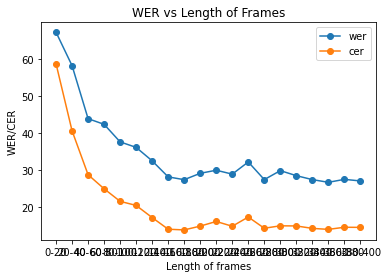

In [381]:
sk = 0
ek = 20
data_wer = [bin_dict[i]['wer'] for i in range(len(len_bins))][sk:ek]
data_cer = [bin_dict[i]['cer'] for i in range(len(len_bins))][sk:ek]
keys = [f'{start}-{end}' for start, end in len_bins][sk:ek]
# rotation=90
plt.plot(keys, data_wer, 'o-', label='wer')
plt.plot(keys, data_cer, 'o-', label='cer')
plt.xlabel('Length of frames')
plt.ylabel('WER/CER')
plt.title('WER vs Length of Frames')
plt.legend()
plt.show()

In [285]:
outs['speakers_unique'] = [len(set(el)) for el in outs['speakers']]

In [291]:
interval = 1
max_len = max([el for el in outs['speakers_unique']])

bin_dict = {el:{'refs': [], 'hyps': []} for el in set(outs['speakers_unique'])}

for i in range(len(outs['hyps'])):
    length = outs['speakers_unique'][i]
    bin_index = length
    bin_dict[bin_index]['refs'].append(outs['refs'][i])
    bin_dict[bin_index]['hyps'].append(outs['hyps'][i])
    
for k in bin_dict.keys():
    wer = word_error_rate(hypotheses=bin_dict[k]['hyps'], references=bin_dict[k]['refs'], use_cer=False)
    cer = word_error_rate(hypotheses=bin_dict[k]['hyps'], references=bin_dict[k]['refs'], use_cer=True)
    bin_dict[k]['wer'] = wer *100
    bin_dict[k]['cer'] = cer *100

In [292]:
sorted(list(bin_dict.keys()))

[1, 2, 3, 4, 5]

In [293]:
len(bin_dict[2]['refs'])

121

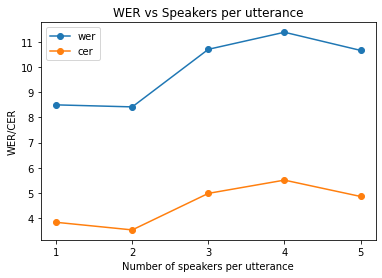

In [294]:
data_wer = [bin_dict[i]['wer'] for i in sorted(list(bin_dict.keys()))]
data_cer = [bin_dict[i]['cer'] for i in sorted(list(bin_dict.keys()))]
keys = [str(key) for key in sorted(list(bin_dict.keys()))]
# rotation=90
plt.plot(keys, data_wer, 'o-', label='wer')
plt.plot(keys, data_cer, 'o-', label='cer')
plt.xlabel('Number of speakers per utterance')
plt.ylabel('WER/CER')
plt.title('WER vs Speakers per utterance')
plt.legend()
plt.show()

In [347]:
interval = 200
max_len = max([len(el) for el in outs['refs']])
len_bins_start = [i for i in range(0, max_len, interval)]
len_bins_end = [i for i in range(interval, max_len+interval, interval)]
len_bins = list(zip(len_bins_start, len_bins_end))

def get_bin_index(length):
    for i, (start, end) in enumerate(len_bins):
        if start <= length < end:
            return i
    return -1

bin_dict = {i: [] for i in range(len(len_bins))}

for i in range(len(outs['hyps'])):
    length = len(outs['refs'][i])
    bin_index = get_bin_index(length)
    bin_dict[bin_index].append(outs['speakers_unique'][i])
    
for k in bin_dict.keys():
    print(f'{k}: sample size {len(bin_dict[k])} \n average speakers per utterance {np.mean(bin_dict[k])} \n')
    print(f'median speakers per utterance {np.median(bin_dict[k])} \n')
    print(f'min speakers per utterance {np.min(bin_dict[k])} \n')
    print(f'max speakers per utterance {np.max(bin_dict[k])} \n')

0: sample size 9 
 average speakers per utterance 3.888888888888889 

median speakers per utterance 4.0 

min speakers per utterance 3 

max speakers per utterance 4 

1: sample size 175 
 average speakers per utterance 3.8514285714285714 

median speakers per utterance 4.0 

min speakers per utterance 2 

max speakers per utterance 5 

2: sample size 580 
 average speakers per utterance 3.8689655172413793 

median speakers per utterance 4.0 

min speakers per utterance 2 

max speakers per utterance 4 

3: sample size 996 
 average speakers per utterance 3.8433734939759034 

median speakers per utterance 4.0 

min speakers per utterance 2 

max speakers per utterance 5 

4: sample size 1092 
 average speakers per utterance 3.7554945054945055 

median speakers per utterance 4.0 

min speakers per utterance 2 

max speakers per utterance 5 

5: sample size 711 
 average speakers per utterance 3.6582278481012658 

median speakers per utterance 4.0 

min speakers per utterance 1 

max spe

In [341]:
len_bins[5]

(1000, 1200)

In [342]:
bin_dict[5]

3.6582278481012658

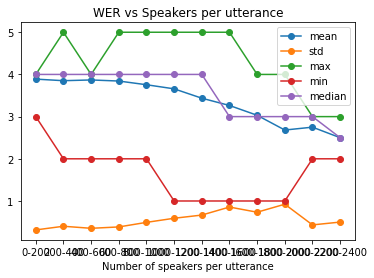

In [353]:


keys = [f'{start}-{end}' for start, end in len_bins]
# rotation=90
plt.plot(keys, [np.array(bin_dict[i]).mean() for i in sorted(list(bin_dict.keys()))], 'o-', label='mean')
plt.plot(keys, [np.array(bin_dict[i]).std() for i in sorted(list(bin_dict.keys()))], 'o-', label='std')
plt.plot(keys, [np.array(bin_dict[i]).max() for i in sorted(list(bin_dict.keys()))], 'o-', label='max')
plt.plot(keys, [np.array(bin_dict[i]).min() for i in sorted(list(bin_dict.keys()))], 'o-', label='min')
plt.plot(keys, [np.median(np.array(bin_dict[i])) for i in sorted(list(bin_dict.keys()))], 'o-', label='median')
plt.xlabel('Number of speakers per utterance')
plt.title('WER vs Speakers per utterance')
plt.legend()
plt.show()